In [0]:
pip install wordcloud

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install pyLDAvis 

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
#pip install pickle

In [0]:
pip install nltk

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install gensim

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
glos_comm = spark.read.parquet("/FileStore/glossier/glossier_comments")

cols = ("author_cakeday","author_flair_css_class","author_flair_text","permalink","stickied","gilded","distinguished","can_gild","retrieved_on","edited")
glos_comm = glos_comm.drop(*cols)
glos_comm = glos_comm.withColumn("created_utc",glos_comm.created_utc.cast('timestamp'))

glos_comm.createOrReplaceTempView("glos_comm_vw")
glos_comm_final = glos_comm

glos_sub = spark.read.parquet("/FileStore/glossier/glossier_submissions")


cols = ("whitelist_status","url","thumbnail_width","thumbnail_height","thumbnail","third_party_tracking_2","third_party_tracking","third_party_trackers","suggested_sort",
       "secure_media_embed", "retrieved_on", "promoted_url", "parent_whitelist_status", "link_flair_text", "link_flair_css_class", "imp_pixel", "href_url", "gilded", "embed_url", 
       "author_flair_css_class", "author_cakeday","adserver_imp_pixel", "adserver_click_url", "secure_media_embed", "secure_media", "post_hint", "permalink", "original_link", 
       "mobile_ad_url", "embed_type", "domain_override", "domain", "author", "preview", "author_flair_text", "edited", "crosspost_parent_list", "media", "media_embed")
glos_sub = glos_sub.drop(*cols)

glos_sub_final = glos_sub.withColumn("created_utc",glos_sub.created_utc.cast('timestamp'))

In [0]:
top_prods = glos_comm_final.select("body")
new = glos_sub_final.select("title").alias("body")


In [0]:
df = top_prods.union(new)

In [0]:
import re
import pandas
dfnew = df.toPandas()
# removing punctuation
dfnew['text_processed'] = \
dfnew['body'].map(lambda x: re.sub('[,\.!?]', '', x))
# all words to lowercase
dfnew['text_processed'] = \
dfnew['text_processed'].map(lambda x: x.lower())
dfnew['text_processed'].head()

Out[4]: 0    i just got an email from them saying that the ...
1    milk kush is also a good dupe for glossier las...
2    i have dry skin and love wowder it sets and bl...
3    hi all if you’d like to use my bff code please...
4    glossier balm dot com it’s the only chapstick ...
Name: text_processed, dtype: object

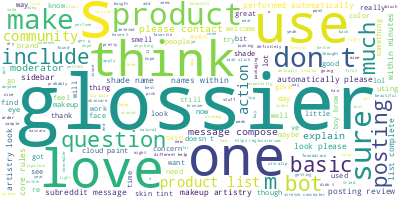

In [0]:
# importing the wordcloud library
from wordcloud import WordCloud
# join the different processed comments together.
long_string = ','.join(list(dfnew['text_processed'].values))
# creating WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# generating word cloud
wordcloud.generate(long_string)
# visualizing
wordcloud.to_image()

In [0]:
#print(long_string[0:10])
import pandas as pd
def Convert(string):
    li = list(string.split(" "))
    return li
lst = Convert(long_string)
df = pd.DataFrame(lst)

In [0]:
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer #, StopWordsRemover
sparkDF=spark.createDataFrame(df) 

sparkDF.printSchema()


root
 |-- 0: string (nullable = true)



In [0]:
## defining tokenizer
tokenizer = Tokenizer(outputCol="words")
tokenizer.setInputCol('0')


df_words_token = tokenizer.transform(sparkDF) #.head()
result = df_words_token.withColumn('indword', f.explode(f.col('words'))) \
  .groupBy('indword') \
  .count().sort('count', ascending=False).limit(20)

In [0]:
#preparing data for LDA Analysis
#transforming the textual data that will serve as input for training LDA model. tokenizing the text, removing stopwords and converting the tokenized object into a corpus and dictionary.

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'bot', 'please', 'like','questions','moderators', 'subreddit','edu', 'use','automatically', 'names', 'sidebar','rules','message','performed','compose','welcome','action','include','sure','within','deleted','list','much', 'glossier', 'minutes','complete'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = dfnew.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# removing stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['got', 'email', 'saying', 'codes', 'apply', 'first', 'order', 'said', 'could', 'make', 'purchase', 'would', 'retroactively', 'refund', 'seems', 'pretty', 'weird']


In [0]:
#print(data_words[0])
#import numpy as np
#counter = np.unique(data_words, return_counts=True)
#counter

#sparkDF1=spark.createDataFrame(data_words) 

#sparkDF1.printSchema()



In [0]:
import gensim.corpora as corpora
# creating dict
id2word = corpora.Dictionary(data_words)
#creating corpus
texts = data_words
#term doc frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [0]:
from pprint import pprint
# num of topics
num_topics = 10
#building LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"skin" + 0.013*"cleanser" + 0.009*"moisturizer" + 0.008*"face" + '
  '0.008*"oil" + 0.007*"using" + 0.007*"also" + 0.006*"super" + 0.006*"serum" '
  '+ 0.006*"one"'),
 (1,
  '0.019*"love" + 0.013*"really" + 0.011*"balm" + 0.009*"also" + 0.008*"look" '
  '+ 0.008*"would" + 0.008*"lip" + 0.007*"lash" + 0.007*"one" + 0.007*"think"'),
 (2,
  '0.010*"one" + 0.009*"skin" + 0.008*"really" + 0.008*"makeup" + '
  '0.007*"finish" + 0.007*"used" + 0.007*"look" + 0.006*"also" + 0.006*"love" '
  '+ 0.005*"hair"'),
 (3,
  '0.016*"lip" + 0.011*"blush" + 0.008*"beauty" + 0.008*"mascara" + '
  '0.007*"shade" + 0.007*"brown" + 0.007*"brow" + 0.006*"palette" + '
  '0.006*"powder" + 0.006*"one"'),
 (4,
  '0.112*"posting" + 0.064*"look" + 0.064*"makeup" + 0.063*"shade" + '
  '0.062*"product" + 0.062*"review" + 0.058*"contact" + 0.057*"concerns" + '
  '0.056*"community" + 0.056*"basics"'),
 (5,
  '0.029*"skin" + 0.018*"concealer" + 0.017*"brow" + 0.016*"tint" + '
  '0.014*"paint" + 0.013*"clou

In [0]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
#visualizing topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))


if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  original_result = python_builtin_import(name, globals, locals, fromlist, level)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-65a7c154-10de-4877-a246-453c35e0ae4a/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [0]:
for idx, topic in lda_model.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: skin|cleanser|moisturizer|face|oil|using|also|super|serum|one
Topic: 1 
Words: love|really|balm|also|look|would|lip|lash|one|think
Topic: 2 
Words: one|skin|really|makeup|finish|used|look|also|love|hair
Topic: 3 
Words: lip|blush|beauty|mascara|shade|brown|brow|palette|powder|one
Topic: 4 
Words: posting|look|makeup|shade|product|review|contact|concerns|community|basics
Topic: 5 
Words: skin|concealer|brow|tint|paint|cloud|stretch|boy|really|also
Topic: 6 
Words: think|would|people|products|one|get|know|lol|good|makeup
Topic: 7 
Words: https|get|code|reglossiercom|user|amp|free|first|order|link
Topic: 8 
Words: one|got|think|removed|would|sale|new|pink|love|perfume
Topic: 9 
Words: amp|us|hoodie|sell|one|lip|shipping|would|want|also


In [0]:
cols = ['Topic Num', 'Top 10 Words']
lst = []
for idx, topic in lda_model.show_topics(formatted=False, num_words= 10):
    lst.append([idx+1, ' | '.join([w[0] for w in topic])])
df1 = pd.DataFrame(lst, columns=cols)
df1

,Topic Num,Top 10 Words
0,1,skin | cleanser | moisturizer | face | oil | u...
1,2,love | really | balm | also | look | would | l...
2,3,one | skin | really | makeup | finish | used |...
3,4,lip | blush | beauty | mascara | shade | brown...
4,5,posting | look | makeup | shade | product | re...
5,6,skin | concealer | brow | tint | paint | cloud...
6,7,think | would | people | products | one | get ...
7,8,https | get | code | reglossiercom | user | am...
8,9,one | got | think | removed | would | sale | n...
9,10,amp | us | hoodie | sell | one | lip | shippin...


In [0]:
df1.to_csv("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/code/data/csv/topicmodel_top_words.csv")